Found 15 images belonging to 15 classes.
1/1 [==============================] - 5s 5s/step
Classification Report:
              precision    recall  f1-score   support

    Anderson       1.00      1.00      1.00         1
      Anibal       1.00      1.00      1.00         1
      Carlos       1.00      1.00      1.00         1
       Cesar       1.00      1.00      1.00         1
       David       1.00      1.00      1.00         1
       Diego       1.00      1.00      1.00         1
    Fabricio       1.00      1.00      1.00         1
        Ivan       1.00      1.00      1.00         1
       Johan       1.00      1.00      1.00         1
        Jose       1.00      1.00      1.00         1
    Justmary       1.00      1.00      1.00         1
       Kevin       1.00      1.00      1.00         1
       Luisa       1.00      1.00      1.00         1
      Teresa       1.00      1.00      1.00         1
        Wong       1.00      1.00      1.00         1

    accuracy        

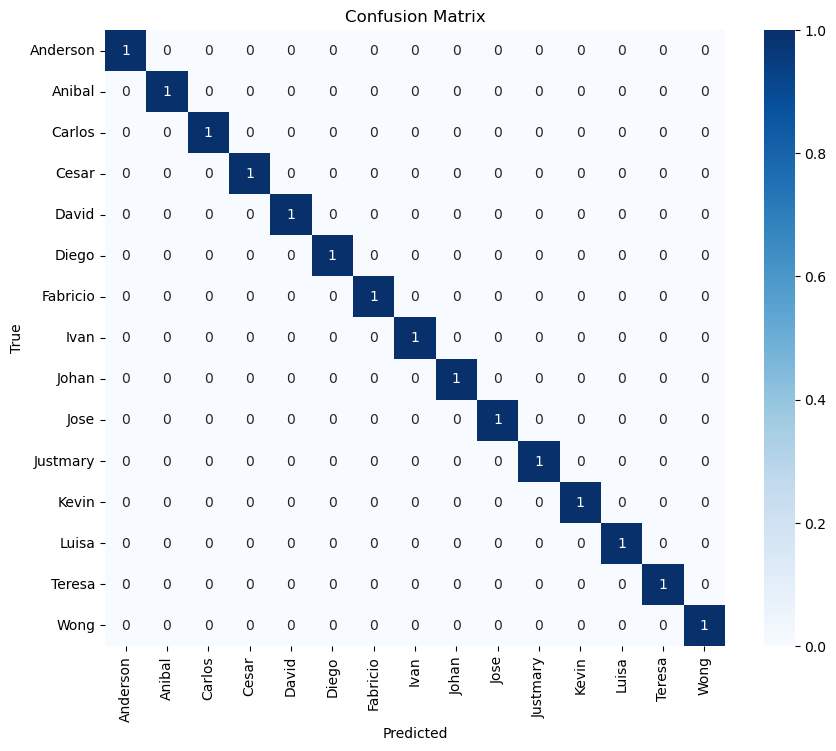

Modelo cargado desde: ../models/re_fa_15_personasV6-gpu.keras
Dimensiones de entrada esperadas: (None, 224, 224, 3)
Número de clases verdaderas: 15
Número de clases predichas: 15
Etiquetas de clase: ['Anderson', 'Anibal', 'Carlos', 'Cesar', 'David', 'Diego', 'Fabricio', 'Ivan', 'Johan', 'Jose', 'Justmary', 'Kevin', 'Luisa', 'Teresa', 'Wong']


In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cargar el modelo entrenado
model_path = '../models/re_fa_15_personasV6-gpu.keras'
model = load_model(model_path)

# Preparar los datos de prueba
test_dir = '../data/processed/test'  # Ruta a tu directorio de datos de prueba
img_height, img_width = 224, 224  # Ajustar según el tamaño de entrada del modelo

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Realizar predicciones
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluar el modelo
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Verificar el modelo cargado
print(f"Modelo cargado desde: {model_path}")
print(f"Dimensiones de entrada esperadas: {model.input_shape}")

# Verificar las clases verdaderas y predichas
print(f"Número de clases verdaderas: {len(true_classes)}")
print(f"Número de clases predichas: {len(predicted_classes)}")
print(f"Etiquetas de clase: {class_labels}")

In [ ]:
# Visualizar algunas predicciones
def plot_predictions(generator, model, class_labels, num_images=14):
    x, y = next(generator)
    predictions = model.predict(x)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)
    
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(x[i])
        plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}")
        plt.axis('off')
    plt.show()
plot_predictions(test_generator, model, class_labels)